## Data Preparation
This notebook is to load and clean up the data from Vancouver listings roughly from 2017-2019

In [13]:
import numpy as np
import pandas as pd
import sqlite3
from IPython.display import Image
import plotly.express as px


**Step 1:** Load the data. The entire dataset can easily fit in memory, so no messing around with SQL. Just load it into a pandas dataframe.

In [14]:
conn = sqlite3.connect('../vancouver_data_series.db')
c = conn.cursor()
raw_df = pd.read_sql_query("SELECT * FROM 'vancouver'",conn)
conn.close()

First, let's select the columns we want to work with for now and drop the rest. We'll add more later, although it will reduce the size of the dataset.

In [15]:
print(raw_df.columns)
n_raw = len(raw_df.index)
df = raw_df[['date','id','latitude','longitude','price','area','bedrooms','unit_type','pets','furnished']]
df['date'] = pd.to_datetime(df['date'],utc=True)
len(df.index)

Index(['date', 'id', 'title', 'latitude', 'longitude', 'address',
       'date_available', 'price', 'area', 'neighbourhood', 'extras',
       'bedrooms', 'bathrooms', 'unit_type', 'parking', 'smoking', 'pets',
       'laundry', 'furnished', 'City', 'location'],
      dtype='object')


/home/bram/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



924653

## Removing Outliers
Now, we should remove outliers. These are values that don't make sense and are much more likely to errors than real data points. We'll plot the histogram of the variables to see that we have captured the majority of the distribution.

In [16]:
min_area = 200
max_area = 5000
min_price = 500 
# people often create listings that are just rooms, rather than whole apartments. We want to be aggressive about filtering those out.
# Potentially we'll take out some micro-units and social housing here, but it should be okay
max_price = 7000
max_bedrooms = 10

top_lat = 49.4
bot_lat = 49.0

the_west = -123.4
the_east = -121.5

df = df[df['latitude'] < top_lat]
df = df[df['latitude'] > bot_lat]

df = df[df['longitude'] < the_east]
df = df[df['bedrooms'] > the_west]


# start_date = June-01-2017
# end_date = Aug-01-2019

df = df[df['area'] > min_area] 
df = df[df['area'] < max_area]
df = df[df['price'] > min_price] 
df = df[df['price'] < max_price]
df = df[df['bedrooms'] < max_bedrooms]

# dates
start_date = pd.to_datetime("2017-06-15T10:00:00-07:00",utc=True)
stop_date = pd.to_datetime("2019-07-26T10:00:00-07:00",utc=True)
df = df[df['date'] > start_date]
df = df[df['date'] < stop_date]



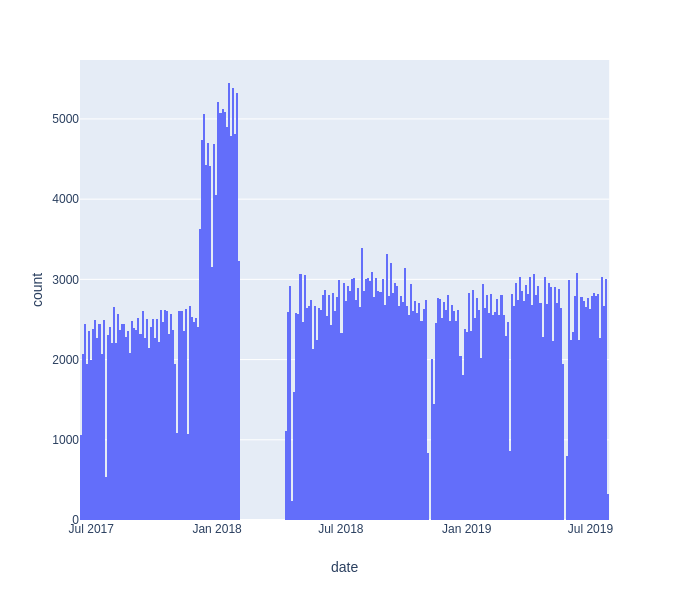

In [17]:
fig = px.histogram(df,x='date')
img = fig.to_image(format='png')
Image(img)

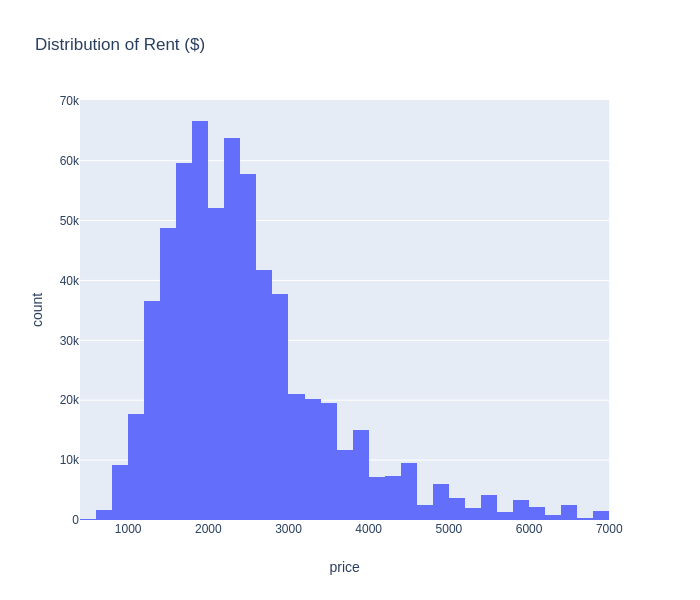

In [18]:
fig = px.histogram(df,x='price',nbins=50,title='Distribution of Rent ($)')
img = fig.to_image(format='png')
Image(img)

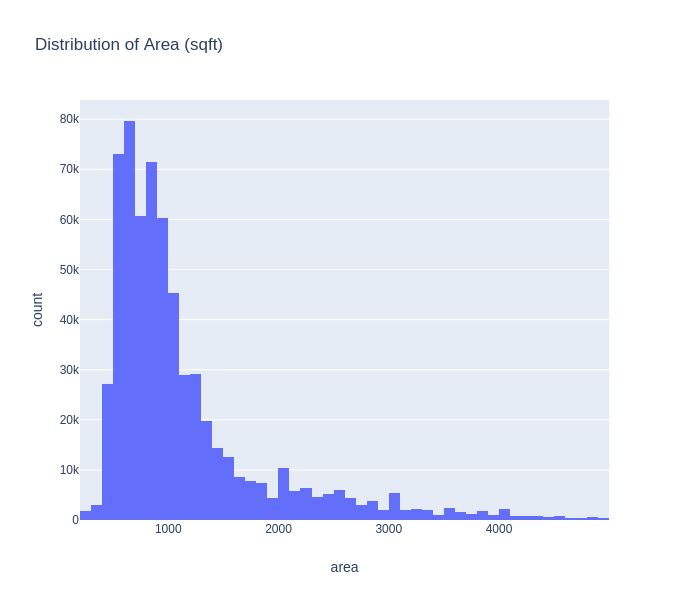

In [19]:
fig = px.histogram(df,x='area',nbins=50,title='Distribution of Area (sqft)')
img = fig.to_image(format='png')
Image(img)

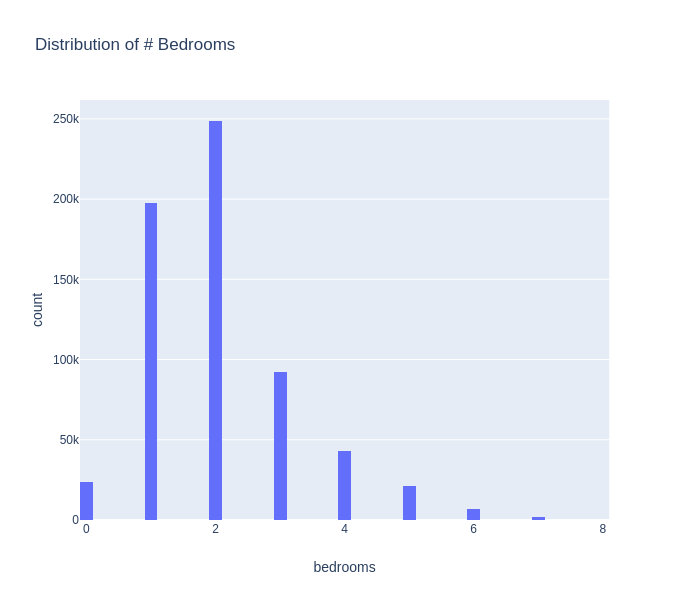

In [20]:
fig = px.histogram(df,x='bedrooms',nbins=50,title='Distribution of # Bedrooms')
img = fig.to_image(format='png')
Image(img)

## Remove Duplicate Listings
Duplicate listings are pretty common. We should do what we can to reduce them.

In [21]:
df = df.drop_duplicates(subset='id')
# I was worried that craigslist might re-use URLs but it doesn't appear to be the case

## Deal with missing data
The next step is to make sure the dataset is complete. Missing data is extremely common on these postings. 
1. Area: Mandatory
2. Price: Mandatory
3. Lat/Long: Mandatory
4. ID: Mandatory
5. Date: Mandatory
6. Bedrooms: Mandatory
7. Unit Type: Mandatory
8. Pets: Assume no unless listed
9. Furnished: Assume no unless listed

In [22]:
# Enforce Mandatory Fields

s0 = len(df.index)
df = df.dropna(subset=['unit_type','bedrooms','latitude','longitude','id','date','area','price'])
s1 = len(df.index)
print("Required mandatory fields removes {:.2%}% of data".format((s0-s1)/s0))

# If Pets or Furnished is None, set to 0
df['pets'] = df['pets'].fillna(value=0)
df['pets'] = df['furnished'].fillna(value=0)

n_clean = len(df.index)
print("Data cleaning complete. Removed {:.2%}% of data".format((n_raw-n_clean)/n_raw))

Required mandatory fields removes 3.93%% of data
Data cleaning complete. Removed 66.53%% of data


## Normalize the Data

In [29]:
norm_df = pd.DataFrame()
norm_df['date'] = df['date']
norm_df['latitude'] = (df['latitude']-df['latitude'].median())/df['latitude'].std()
norm_df['longitude'] = (df['longitude']-df['longitude'].median())/df['longitude'].std()
norm_df['area'] = (df['area']-df['area'].median())/df['area'].std()
norm_df['date'] = df['date'].astype(int)/1e9
norm_df['date'] = (norm_df['date'] - norm_df['date'].min())/(norm_df['date'].max() - norm_df['date'].min())


# code the bedrooms as binary variables

norm_df['studio'] = (df['bedrooms']==0.0).astype(int)
norm_df['1_bed'] = (df['bedrooms']==1.0).astype(int)
norm_df['2_bed'] = (df['bedrooms']==2.0).astype(int)
norm_df['3_bed'] = (df['bedrooms']==3.0).astype(int)
norm_df['4_bed'] = (df['bedrooms']==4.0).astype(int)
norm_df['5_bed'] = (df['bedrooms']==5.0).astype(int)
norm_df['6_bed'] = (df['bedrooms']==6.0).astype(int)
norm_df['mansion'] = (df['bedrooms']>=7.0).astype(int)

# code the unit type as binary variables

norm_df['apartment'] = (df['unit_type']=="apartment").astype(int)
norm_df['condo'] = (df['unit_type']=="condo").astype(int)
norm_df['house'] = (df['unit_type']=="house").astype(int)
norm_df['townhouse'] = (df['unit_type']=="townhouse").astype(int)

norm_df['pets'] = df['pets']
norm_df['furnished'] = df['furnished']

norm_df['price'] = (df['price']-df['price'].median())/df['price'].std()

norm

In [30]:
norm_df.to_pickle("clean_dataset.pickle")